In [1]:
#!pip install lime


In [1]:
import numpy as np
import pandas as pd
from keras.models import load_model
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random
from tensorflow.keras.datasets import mnist
from lime.wrappers.scikit_image import SegmentationAlgorithm
import skimage
from skimage.color import label2rgb



import tensorflow as tf
from tensorflow import keras

c:\Users\cpt\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Cargamos el modelo guardado.
cnn_minist = load_model('../1.0 MNIST (keras) - Modelo/trained_model/')

# Comprobamos que se ha cargado bien visualizando la secuencia de capas.
cnn_minist.summary()

Model: "keras_neuronal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  692352    
                                                                 
 dense_1 (Dense)             multiple                  1290      
                                                                 
Total params: 694,538
Trainable params: 694,538
Non-trainable params: 0
______________________________________________

Keras tiene el conjunto de datos MNIST como parte de su distribución, el cual se puede cargar utilizando el método load_data() del módulo mnist. Este método devuelve dos tuplas que representan los datos de entrenamiento y prueba organizados para el aprendizaje supervisado, por lo que hemos utilizado x e y para representar la imagen y la etiqueta objetivo, respectivamente.

Ahora bien, la imagen devuelta es un vector numpy unidimensional de tamaño 784, que se convierte de entero a float32 y se transforma en una matriz bidimensional de tamaño 28x28. Dado que la imagen es en escala de grises, los valores de sus píxeles van desde 0 hasta 255, por lo tanto, la normalizamos dividiéndolos por 255.0. Este paso es una etapa de preprocesamiento importante, ya que los números grandes aumentan la complejidad del entrenamiento, por lo tanto, se recomienda normalizarlos entre 0 y 1.

In [5]:
# Cargamos los datos de entrenamiento y prueba en sendos arrays.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

X_train = X_train.reshape((-1,28,28,1)) / 255.0 
X_test = X_test.reshape((-1,28,28,1)) / 255.0 

In [6]:
# Creamos la función de conversión al tipo RGB.
import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

# La aplicamos a los dos data sets.
X_train = to_rgb(X_train)
X_test = to_rgb(X_test)

Dado que el módulo "lime" que estamos utilizando solo funciona con imágenes de 3 dimensiones, es decir, imágenes que tienen 3 canales generalmente RGB, aquí replicamos el plano de escala de grises. Este segmento de código convierte una imagen en escala de grises a RGB simplemente replicando el plano disponible.

In [7]:
print(X_train.shape, X_test.shape)

(60000, 28, 28, 3) (10000, 28, 28, 3)


"y_train" almacena la etiqueta real de cada imagen en el conjunto de datos de entrenamiento.

In [8]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Ahora obtenemos "y_pred_train", que almacena las predicciones del modelo sobre los datos de imagen de entrenamiento, "X_train". La predicción por imagen es un vector unidimensional de 10 números y extraemos la etiqueta encontrando la posición del índice del número con el valor máximo. Luego, comparamos las etiquetas predichas y reales, y contamos el número de predicciones incorrectas.

In [9]:
# Obtenemos las predicciones sobre el conjunto de entrenamiento.
y_pred_train = cnn_minist.predict(X_train)

# La comparamos con las etiquetas originales.
bad_predictions = (y_pred_train.argmax(axis=1) != y_train)

# Las publicamos en pantalla.
print('Bad predictions:', sum(bad_predictions))

1875/1875 [==============================] - 5s 2ms/step
Bad predictions: 931


Nuestro modelo está listo y es hora de usar LIME para la Explicabilidad de la Inteligencia Artificial (XAI, por sus siglas en inglés). Utilizando el módulo "lime_image" del paquete LIME, creamos un objeto "explainer" de la clase "LimeImageExplainer()". Este objeto tiene un método llamado "explain_instance()" que toma datos de imagen tridimensionales y una función predictor, en este caso "model.predict". Basándose en las predicciones realizadas por la función predict del modelo, devuelve una explicación.

El objeto "explanation" tiene un método llamado "get_image_and_mask()" que toma las etiquetas predichas correspondientes a los datos de imagen tridimensionales analizados anteriormente y los devuelve como una tupla "(image, mask)", donde la imagen es un array numpy tridimensional y la máscara es un array numpy bidimensional que se puede usar con "skimage.segmentation.mark_boundaries". La imagen devuelta junto con la máscara correspondiente representa las características en la imagen responsables de la predicción.

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 20/1000 [00:00<00:06, 153.08it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 50/1000 [00:00<00:05, 188.70it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 80/1000 [00:00<00:04, 207.92it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 110/1000 [00:00<00:04, 214.46it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 140/1000 [00:00<00:03, 217.49it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 170/1000 [00:00<00:03, 219.73it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 200/1000 [00:00<00:03, 224.69it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 230/1000 [00:01<00:03, 228.41it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 260/1000 [00:01<00:03, 228.51it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 290/1000 [00:01<00:03, 229.55it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 320/1000 [00:01<00:03, 217.35it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 350/1000 [00:01<00:03, 215.60it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 220.63it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 410/1000 [00:01<00:02, 223.77it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 440/1000 [00:02<00:02, 224.13it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 470/1000 [00:02<00:02, 226.32it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 500/1000 [00:02<00:02, 224.24it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 530/1000 [00:02<00:02, 225.15it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 226.97it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 223.71it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 224.60it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 643/1000 [00:02<00:01, 219.67it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 670/1000 [00:03<00:01, 215.31it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 700/1000 [00:03<00:01, 218.42it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 730/1000 [00:03<00:01, 222.34it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 760/1000 [00:03<00:01, 224.07it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 790/1000 [00:03<00:00, 225.23it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 820/1000 [00:03<00:00, 225.52it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 850/1000 [00:03<00:00, 221.24it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 873/1000 [00:03<00:00, 208.90it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 900/1000 [00:04<00:00, 208.71it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 930/1000 [00:04<00:00, 216.49it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 960/1000 [00:04<00:00, 216.95it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 990/1000 [00:04<00:00, 220.20it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 1000/1000 [00:04<00:00, 219.86it/s]


1/1 [==============================] - 0s 17ms/step


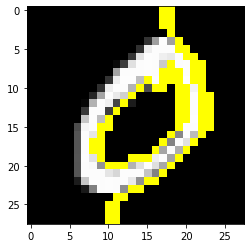

In [10]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(X_train[1], cnn_minist.predict)
plt.imshow(X_train[1])
temp, mask = explanation.get_image_and_mask(cnn_minist.predict(X_train[1].reshape((1,28,28,3))).argmax(axis=1)[0], positive_only=True, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

In [11]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [12]:
%%time
explanation = explainer.explain_instance(X_test[0], 
                                         classifier_fn = cnn_minist.predict, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 30/10000 [00:00<00:46, 216.34it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 60/10000 [00:00<00:43, 226.95it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 90/10000 [00:00<00:43, 227.35it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 120/10000 [00:00<00:42, 229.98it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 150/10000 [00:00<00:43, 227.40it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 180/10000 [00:00<00:44, 222.44it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 210/10000 [00:00<00:43, 226.76it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 240/10000 [00:01<00:42, 228.67it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 270/10000 [00:01<00:42, 229.66it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 300/10000 [00:01<00:42, 230.17it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 330/10000 [00:01<00:41, 231.36it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 360/10000 [00:01<00:42, 228.59it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 390/10000 [00:01<00:41, 228.90it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 420/10000 [00:01<00:41, 229.12it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 450/10000 [00:01<00:41, 228.12it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 480/10000 [00:02<00:41, 228.95it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 503/10000 [00:02<00:43, 219.61it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 530/10000 [00:02<00:44, 214.01it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 560/10000 [00:02<00:42, 220.21it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 590/10000 [00:02<00:41, 224.26it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 620/10000 [00:02<00:41, 225.44it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 650/10000 [00:02<00:41, 225.66it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 680/10000 [00:03<00:42, 221.27it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 710/10000 [00:03<00:41, 224.15it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 740/10000 [00:03<00:41, 221.75it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 770/10000 [00:03<00:41, 223.57it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 793/10000 [00:03<00:41, 220.65it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 820/10000 [00:03<00:42, 213.83it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 850/10000 [00:03<00:42, 214.44it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 880/10000 [00:03<00:42, 215.18it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 910/10000 [00:04<00:41, 216.99it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 940/10000 [00:04<00:41, 216.83it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 970/10000 [00:04<00:41, 217.22it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 1000/10000 [00:04<00:41, 217.45it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 1030/10000 [00:04<00:41, 218.44it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 1060/10000 [00:04<00:41, 216.09it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 1090/10000 [00:04<00:39, 224.25it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 1113/10000 [00:05<00:41, 214.32it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 1140/10000 [00:05<00:42, 210.55it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1170/10000 [00:05<00:42, 210.11it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1200/10000 [00:05<00:41, 210.20it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1230/10000 [00:05<00:41, 209.78it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1260/10000 [00:05<00:41, 209.08it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1290/10000 [00:05<00:41, 208.58it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1320/10000 [00:06<00:41, 209.12it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1350/10000 [00:06<00:41, 208.61it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1380/10000 [00:06<00:40, 210.46it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1410/10000 [00:06<00:40, 212.93it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1432/10000 [00:06<00:41, 204.69it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1460/10000 [00:06<00:41, 203.86it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1490/10000 [00:06<00:40, 211.13it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1520/10000 [00:06<00:39, 215.53it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1550/10000 [00:07<00:38, 219.78it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1580/10000 [00:07<00:37, 222.70it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1610/10000 [00:07<00:37, 222.74it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1640/10000 [00:07<00:37, 225.86it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1670/10000 [00:07<00:37, 224.29it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1700/10000 [00:07<00:37, 220.22it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1723/10000 [00:07<00:38, 215.38it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1750/10000 [00:08<00:39, 210.15it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1780/10000 [00:08<00:38, 214.03it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1810/10000 [00:08<00:37, 218.66it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1840/10000 [00:08<00:36, 220.80it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 1870/10000 [00:08<00:36, 220.53it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1900/10000 [00:08<00:37, 218.78it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1930/10000 [00:08<00:36, 220.43it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 1960/10000 [00:08<00:36, 221.07it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1990/10000 [00:09<00:36, 220.60it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 2020/10000 [00:09<00:36, 219.82it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 2042/10000 [00:09<00:36, 217.92it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2070/10000 [00:09<00:37, 211.36it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 2100/10000 [00:09<00:36, 214.38it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 2130/10000 [00:09<00:36, 216.89it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2160/10000 [00:09<00:36, 212.64it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 2182/10000 [00:09<00:37, 206.21it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2210/10000 [00:10<00:38, 203.52it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2240/10000 [00:10<00:37, 206.57it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2261/10000 [00:10<00:38, 201.73it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2290/10000 [00:10<00:37, 204.97it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2320/10000 [00:10<00:36, 209.56it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 2350/10000 [00:10<00:35, 213.56it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2380/10000 [00:10<00:35, 217.32it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 2410/10000 [00:11<00:35, 216.56it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2440/10000 [00:11<00:34, 218.43it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 2462/10000 [00:11<00:34, 218.43it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2484/10000 [00:11<00:34, 217.32it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 2506/10000 [00:11<00:34, 217.03it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 2528/10000 [00:11<00:34, 217.41it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 2550/10000 [00:11<00:42, 175.44it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2570/10000 [00:11<00:41, 180.68it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2590/10000 [00:12<00:40, 182.04it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2610/10000 [00:12<00:39, 186.45it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 2630/10000 [00:12<00:38, 189.79it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 2650/10000 [00:12<00:38, 191.73it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2671/10000 [00:12<00:37, 196.54it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2691/10000 [00:12<00:38, 191.61it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2711/10000 [00:12<00:38, 191.43it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2731/10000 [00:12<00:38, 189.16it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2751/10000 [00:12<00:39, 182.51it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2770/10000 [00:12<00:41, 174.98it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2790/10000 [00:13<00:41, 175.26it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2810/10000 [00:13<00:40, 177.80it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2830/10000 [00:13<00:39, 182.57it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 2860/10000 [00:13<00:36, 194.02it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2890/10000 [00:13<00:35, 200.03it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2910/10000 [00:13<00:35, 198.65it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 2930/10000 [00:13<00:36, 192.52it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2950/10000 [00:13<00:37, 189.09it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2970/10000 [00:14<00:39, 178.64it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2990/10000 [00:14<00:38, 181.55it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 3010/10000 [00:14<00:38, 182.74it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 3040/10000 [00:14<00:36, 191.04it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 3070/10000 [00:14<00:34, 198.39it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 3090/10000 [00:14<00:35, 196.95it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 3120/10000 [00:14<00:33, 202.89it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 3141/10000 [00:14<00:33, 203.29it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 3162/10000 [00:14<00:33, 203.60it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3190/10000 [00:15<00:34, 200.09it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 3211/10000 [00:15<00:33, 202.27it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 3240/10000 [00:15<00:33, 201.19it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3261/10000 [00:15<00:37, 178.19it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 3280/10000 [00:15<00:37, 179.01it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 3300/10000 [00:15<00:37, 177.27it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 3320/10000 [00:15<00:37, 178.22it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 3340/10000 [00:15<00:36, 183.15it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 3368/10000 [00:16<00:31, 209.23it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 3390/10000 [00:16<00:35, 187.70it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 3420/10000 [00:16<00:33, 195.31it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3440/10000 [00:16<00:34, 192.71it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 3460/10000 [00:16<00:34, 190.75it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 3480/10000 [00:16<00:34, 191.21it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 3500/10000 [00:16<00:34, 186.61it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███▌      | 3520/10000 [00:16<00:34, 188.07it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 3540/10000 [00:17<00:36, 176.46it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 3560/10000 [00:17<00:35, 179.55it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 3580/10000 [00:17<00:36, 177.99it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 3600/10000 [00:17<00:35, 182.15it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 3630/10000 [00:17<00:33, 192.24it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3660/10000 [00:17<00:31, 199.75it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3690/10000 [00:17<00:30, 205.08it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3720/10000 [00:17<00:29, 210.05it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3750/10000 [00:18<00:29, 212.00it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 3772/10000 [00:18<00:30, 203.25it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 3800/10000 [00:18<00:30, 201.49it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3830/10000 [00:18<00:29, 206.98it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 3851/10000 [00:18<00:29, 207.36it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 3880/10000 [00:18<00:29, 205.03it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 3910/10000 [00:18<00:28, 210.01it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3940/10000 [00:18<00:28, 212.05it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 3970/10000 [00:19<00:28, 214.42it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 4000/10000 [00:19<00:27, 216.01it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 4022/10000 [00:19<00:29, 205.28it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 4050/10000 [00:19<00:29, 202.84it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 4080/10000 [00:19<00:28, 207.44it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 4110/10000 [00:19<00:28, 210.25it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 4140/10000 [00:19<00:27, 211.03it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 4170/10000 [00:20<00:27, 214.07it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 4200/10000 [00:20<00:26, 215.63it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 4230/10000 [00:20<00:27, 213.55it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 4260/10000 [00:20<00:26, 214.40it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 4282/10000 [00:20<00:27, 208.03it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4303/10000 [00:20<00:27, 204.64it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 4330/10000 [00:20<00:28, 198.69it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 4360/10000 [00:20<00:27, 202.86it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 4390/10000 [00:21<00:27, 204.76it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 4420/10000 [00:21<00:26, 207.83it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 4450/10000 [00:21<00:26, 208.63it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 4480/10000 [00:21<00:26, 206.07it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 4510/10000 [00:21<00:26, 209.55it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 4531/10000 [00:21<00:27, 198.69it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 4560/10000 [00:21<00:27, 198.84it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 4590/10000 [00:22<00:26, 202.40it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 4620/10000 [00:22<00:26, 203.09it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 4650/10000 [00:22<00:26, 204.42it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 4680/10000 [00:22<00:25, 206.01it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 4710/10000 [00:22<00:25, 206.77it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 4740/10000 [00:22<00:25, 208.90it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4770/10000 [00:22<00:25, 205.45it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 4791/10000 [00:23<00:26, 198.05it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 4820/10000 [00:23<00:25, 200.55it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 4850/10000 [00:23<00:25, 200.97it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 4871/10000 [00:23<00:25, 202.73it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 4900/10000 [00:23<00:24, 204.30it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 4930/10000 [00:23<00:24, 205.76it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4951/10000 [00:23<00:24, 205.44it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4980/10000 [00:24<00:24, 204.75it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 5010/10000 [00:24<00:24, 205.17it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 5031/10000 [00:24<00:25, 191.73it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 5060/10000 [00:24<00:25, 196.22it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 5090/10000 [00:24<00:24, 198.01it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 5110/10000 [00:24<00:25, 192.74it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 5130/10000 [00:24<00:25, 193.23it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 5160/10000 [00:24<00:24, 197.54it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 5190/10000 [00:25<00:23, 201.64it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 5211/10000 [00:25<00:24, 198.77it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 5231/10000 [00:25<00:24, 196.24it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 5251/10000 [00:25<00:26, 180.24it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 5270/10000 [00:25<00:26, 179.65it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 5290/10000 [00:25<00:25, 182.49it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 5310/10000 [00:25<00:25, 185.37it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 5330/10000 [00:25<00:24, 186.98it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 5350/10000 [00:25<00:24, 189.82it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 5370/10000 [00:26<00:25, 184.97it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 5390/10000 [00:26<00:25, 183.67it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 5410/10000 [00:26<00:24, 186.31it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 5430/10000 [00:26<00:24, 187.68it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 5450/10000 [00:26<00:25, 177.66it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 5470/10000 [00:26<00:25, 177.60it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 5490/10000 [00:26<00:24, 182.90it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 5510/10000 [00:26<00:24, 185.77it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 5530/10000 [00:26<00:24, 181.71it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 5550/10000 [00:27<00:24, 184.39it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 5570/10000 [00:27<00:24, 183.26it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 5590/10000 [00:27<00:23, 185.00it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 5610/10000 [00:27<00:23, 185.72it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 5630/10000 [00:27<00:23, 186.23it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 5650/10000 [00:27<00:26, 162.94it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 5670/10000 [00:27<00:27, 159.09it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5690/10000 [00:27<00:26, 162.59it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 5710/10000 [00:28<00:25, 166.79it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 5730/10000 [00:28<00:25, 166.06it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▊    | 5750/10000 [00:28<00:36, 116.30it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 5770/10000 [00:28<00:31, 132.80it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 5790/10000 [00:28<00:28, 147.13it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 5810/10000 [00:28<00:26, 158.76it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 5830/10000 [00:28<00:27, 149.64it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 5850/10000 [00:28<00:26, 157.39it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 5870/10000 [00:29<00:24, 166.16it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 5890/10000 [00:29<00:23, 174.26it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 5910/10000 [00:29<00:23, 177.06it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 5930/10000 [00:29<00:22, 177.19it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 5950/10000 [00:29<00:22, 182.10it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 5970/10000 [00:29<00:21, 186.74it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 5990/10000 [00:29<00:21, 185.91it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6010/10000 [00:29<00:23, 170.22it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 6030/10000 [00:29<00:22, 172.78it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 6050/10000 [00:30<00:22, 175.53it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 6070/10000 [00:30<00:22, 177.04it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 6090/10000 [00:30<00:21, 181.01it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 6120/10000 [00:30<00:20, 193.19it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 6150/10000 [00:30<00:18, 203.63it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 6180/10000 [00:30<00:18, 209.48it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 6210/10000 [00:30<00:18, 210.22it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 6240/10000 [00:30<00:17, 214.55it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6270/10000 [00:31<00:17, 218.74it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6300/10000 [00:31<00:16, 218.02it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 6322/10000 [00:31<00:16, 216.54it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 6350/10000 [00:31<00:17, 208.34it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 6380/10000 [00:31<00:17, 209.98it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 6410/10000 [00:31<00:16, 211.98it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6440/10000 [00:31<00:16, 214.52it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 6470/10000 [00:32<00:16, 216.22it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 6500/10000 [00:32<00:15, 218.91it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 6530/10000 [00:32<00:15, 219.92it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 6560/10000 [00:32<00:15, 218.85it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 6590/10000 [00:32<00:15, 220.17it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 6620/10000 [00:32<00:15, 221.93it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 6650/10000 [00:32<00:15, 221.83it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6680/10000 [00:32<00:14, 224.52it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6710/10000 [00:33<00:14, 225.68it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6740/10000 [00:33<00:14, 224.31it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 6770/10000 [00:33<00:14, 218.97it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6800/10000 [00:33<00:14, 216.31it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 6830/10000 [00:33<00:14, 212.31it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 6860/10000 [00:33<00:14, 212.17it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 6890/10000 [00:33<00:14, 209.41it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 6920/10000 [00:34<00:14, 210.13it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 6942/10000 [00:34<00:15, 202.73it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 6970/10000 [00:34<00:15, 200.22it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 6996/10000 [00:34<00:14, 214.19it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 7020/10000 [00:34<00:15, 197.93it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 7050/10000 [00:34<00:14, 200.78it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 7080/10000 [00:34<00:14, 203.74it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 7101/10000 [00:35<00:14, 204.79it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 7130/10000 [00:35<00:14, 202.50it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 7151/10000 [00:35<00:14, 202.98it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7172/10000 [00:35<00:14, 195.40it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 7192/10000 [00:35<00:14, 187.51it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7220/10000 [00:35<00:14, 191.68it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 7240/10000 [00:35<00:15, 176.15it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 7260/10000 [00:35<00:15, 180.83it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 7280/10000 [00:36<00:15, 174.20it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7300/10000 [00:36<00:15, 179.60it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 7320/10000 [00:36<00:14, 180.84it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 7340/10000 [00:36<00:14, 180.79it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 7360/10000 [00:36<00:14, 178.85it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 7380/10000 [00:36<00:14, 182.78it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 7400/10000 [00:36<00:14, 185.15it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 7420/10000 [00:36<00:14, 183.79it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 7440/10000 [00:36<00:13, 184.35it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7460/10000 [00:36<00:13, 184.75it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7490/10000 [00:37<00:12, 196.69it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 7510/10000 [00:37<00:13, 180.36it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 7540/10000 [00:37<00:13, 188.17it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7570/10000 [00:37<00:12, 194.68it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7600/10000 [00:37<00:12, 199.15it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 7630/10000 [00:37<00:11, 200.52it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7660/10000 [00:37<00:11, 205.26it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7690/10000 [00:38<00:11, 208.25it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7720/10000 [00:38<00:10, 207.98it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 7741/10000 [00:38<00:10, 207.61it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 7762/10000 [00:38<00:11, 200.34it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 7790/10000 [00:38<00:11, 197.67it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 7819/10000 [00:38<00:09, 220.34it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 7842/10000 [00:38<00:10, 201.65it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 7870/10000 [00:39<00:10, 200.59it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7900/10000 [00:39<00:10, 202.68it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7930/10000 [00:39<00:10, 205.52it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 7960/10000 [00:39<00:09, 210.97it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 7990/10000 [00:39<00:09, 210.74it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 8020/10000 [00:39<00:09, 210.28it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 8050/10000 [00:39<00:09, 213.36it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 8080/10000 [00:40<00:08, 213.37it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 8102/10000 [00:40<00:09, 204.03it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 8123/10000 [00:40<00:09, 204.61it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8150/10000 [00:40<00:09, 200.30it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 8180/10000 [00:40<00:08, 204.35it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8210/10000 [00:40<00:08, 205.83it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 8240/10000 [00:40<00:08, 207.23it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 8261/10000 [00:40<00:08, 207.53it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 8290/10000 [00:41<00:08, 207.30it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 8311/10000 [00:41<00:08, 206.49it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 8332/10000 [00:41<00:08, 206.49it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 8353/10000 [00:41<00:08, 205.38it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 8374/10000 [00:41<00:07, 204.56it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8395/10000 [00:41<00:08, 196.56it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 8420/10000 [00:41<00:08, 190.28it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8450/10000 [00:41<00:07, 194.98it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 8480/10000 [00:41<00:07, 199.49it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 8510/10000 [00:42<00:07, 203.36it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 8540/10000 [00:42<00:07, 202.84it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 8570/10000 [00:42<00:07, 203.95it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 8600/10000 [00:42<00:06, 205.52it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 8621/10000 [00:42<00:06, 205.73it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 8650/10000 [00:42<00:06, 202.80it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 8680/10000 [00:42<00:06, 203.38it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 8710/10000 [00:43<00:06, 197.48it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 8730/10000 [00:43<00:06, 196.39it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 8760/10000 [00:43<00:06, 200.79it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 8790/10000 [00:43<00:05, 203.23it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 8811/10000 [00:43<00:05, 202.57it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 8840/10000 [00:43<00:05, 203.74it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 8870/10000 [00:43<00:05, 206.75it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 8900/10000 [00:44<00:05, 205.19it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8921/10000 [00:44<00:05, 204.53it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 8950/10000 [00:44<00:05, 204.05it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 8971/10000 [00:44<00:05, 195.17it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 8991/10000 [00:44<00:05, 191.34it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 9020/10000 [00:44<00:05, 193.63it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 9050/10000 [00:44<00:04, 195.94it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 9070/10000 [00:44<00:04, 194.71it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 9100/10000 [00:45<00:04, 197.90it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 9127/10000 [00:45<00:04, 215.11it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 9149/10000 [00:45<00:03, 214.27it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9171/10000 [00:45<00:04, 177.56it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9200/10000 [00:45<00:04, 187.80it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9230/10000 [00:45<00:03, 197.06it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 9260/10000 [00:45<00:03, 200.68it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 9281/10000 [00:45<00:03, 202.35it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 9310/10000 [00:46<00:03, 202.44it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 9340/10000 [00:46<00:03, 205.86it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 9370/10000 [00:46<00:03, 208.18it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 9391/10000 [00:46<00:02, 203.88it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 9412/10000 [00:46<00:02, 204.50it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 9440/10000 [00:46<00:02, 202.46it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 9470/10000 [00:46<00:02, 208.76it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 9500/10000 [00:47<00:02, 214.45it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 9522/10000 [00:47<00:02, 210.65it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 9550/10000 [00:47<00:02, 208.30it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 9580/10000 [00:47<00:01, 213.38it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 9610/10000 [00:47<00:01, 213.85it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 9640/10000 [00:47<00:01, 212.81it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 9670/10000 [00:47<00:01, 215.76it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9700/10000 [00:47<00:01, 215.03it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 9722/10000 [00:48<00:01, 209.86it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 9750/10000 [00:48<00:01, 204.59it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 9780/10000 [00:48<00:01, 206.60it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9801/10000 [00:48<00:00, 206.56it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9830/10000 [00:48<00:00, 207.88it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 9860/10000 [00:48<00:00, 210.59it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 9890/10000 [00:48<00:00, 210.52it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 9920/10000 [00:49<00:00, 213.06it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 9942/10000 [00:49<00:00, 209.74it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 9963/10000 [00:49<00:00, 208.88it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 9984/10000 [00:49<00:00, 209.15it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 10000/10000 [00:49<00:00, 202.29it/s]

Wall time: 49.5 s


Text(0.5, 1.0, 'Positive/Negative Regions for 7')

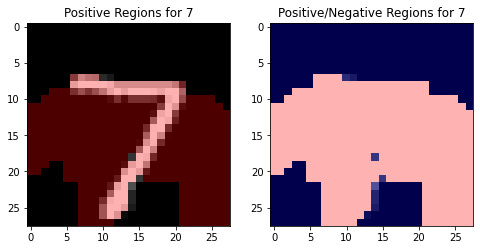

In [13]:
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

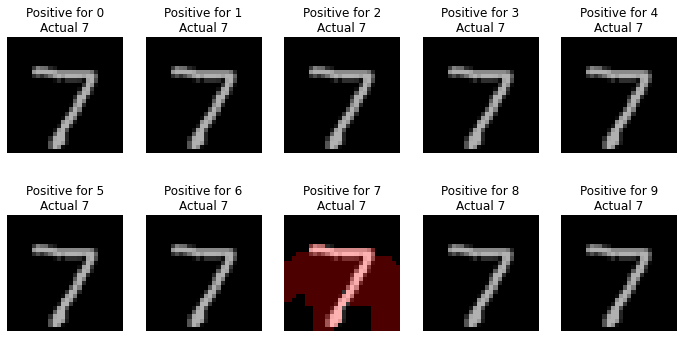

In [14]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[0]))
    c_ax.axis('off')

In [15]:
y_test[0]

7

In [16]:
pipe_pred_test = cnn_minist.predict(X_test)

wrong_idx = np.random.choice(np.where(pipe_pred_test.argmax(axis=1)!=y_test)[0])
pred =  pipe_pred_test[wrong_idx].argmax(axis=0)
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pred))

313/313 [==============================] - 1s 3ms/step
Using #2720 where the label was 9 and the pipeline predicted 4


In [17]:
y_test[wrong_idx]

9

In [18]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx], 
                                         classifier_fn = cnn_minist.predict, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 20/10000 [00:00<00:53, 187.44it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 50/10000 [00:00<00:49, 201.55it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 80/10000 [00:00<00:47, 209.34it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 101/10000 [00:00<00:48, 203.06it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 130/10000 [00:00<00:48, 202.06it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 151/10000 [00:00<00:48, 202.18it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 180/10000 [00:00<00:48, 201.58it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 210/10000 [00:01<00:47, 204.21it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 240/10000 [00:01<00:47, 205.75it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 270/10000 [00:01<00:46, 207.51it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 300/10000 [00:01<00:46, 210.32it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 330/10000 [00:01<00:45, 212.24it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 360/10000 [00:01<00:45, 212.12it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 390/10000 [00:01<00:45, 212.60it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 420/10000 [00:02<00:45, 212.58it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 442/10000 [00:02<00:47, 200.37it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 470/10000 [00:02<00:47, 200.86it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 500/10000 [00:02<00:46, 206.46it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 530/10000 [00:02<00:45, 208.36it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 560/10000 [00:02<00:44, 211.98it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 590/10000 [00:02<00:43, 214.25it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 612/10000 [00:02<00:43, 215.24it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 634/10000 [00:03<00:43, 215.50it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 660/10000 [00:03<00:45, 205.21it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 690/10000 [00:03<00:44, 207.23it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 711/10000 [00:03<00:47, 196.41it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 740/10000 [00:03<00:47, 196.52it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 770/10000 [00:03<00:46, 198.25it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 800/10000 [00:03<00:46, 199.40it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 820/10000 [00:03<00:46, 199.20it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 840/10000 [00:04<00:46, 196.63it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 870/10000 [00:04<00:45, 200.12it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 890/10000 [00:04<00:45, 199.73it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 910/10000 [00:04<00:45, 199.42it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 940/10000 [00:04<00:44, 204.16it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 970/10000 [00:04<00:44, 204.97it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 991/10000 [00:04<00:45, 199.46it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 1011/10000 [00:04<00:45, 199.59it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 1031/10000 [00:05<00:44, 199.52it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 1051/10000 [00:05<00:45, 198.71it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 1071/10000 [00:05<00:44, 198.66it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 1100/10000 [00:05<00:44, 200.46it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 1120/10000 [00:05<00:45, 195.27it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1150/10000 [00:05<00:44, 199.05it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1170/10000 [00:05<00:44, 197.91it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1200/10000 [00:05<00:43, 202.63it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1221/10000 [00:05<00:43, 203.09it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1242/10000 [00:06<00:45, 193.94it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1262/10000 [00:06<00:46, 187.28it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1282/10000 [00:06<00:45, 190.29it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1302/10000 [00:06<00:45, 192.05it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1330/10000 [00:06<00:44, 193.10it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 1350/10000 [00:06<00:44, 192.52it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 1370/10000 [00:06<00:44, 194.17it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1400/10000 [00:06<00:43, 197.47it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1420/10000 [00:07<00:43, 197.24it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1440/10000 [00:07<00:59, 144.14it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1470/10000 [00:07<00:52, 162.10it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1490/10000 [00:07<00:49, 170.23it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1510/10000 [00:07<00:50, 168.92it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1530/10000 [00:07<00:48, 176.30it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1560/10000 [00:07<00:45, 187.28it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1590/10000 [00:08<00:43, 194.44it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1620/10000 [00:08<00:42, 198.13it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1650/10000 [00:08<00:41, 202.33it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1671/10000 [00:08<00:41, 201.50it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1700/10000 [00:08<00:41, 201.63it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1721/10000 [00:08<00:40, 202.82it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1750/10000 [00:08<00:41, 200.81it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1780/10000 [00:08<00:41, 197.69it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1800/10000 [00:09<00:41, 195.56it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1830/10000 [00:09<00:40, 199.56it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1860/10000 [00:09<00:40, 201.62it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1881/10000 [00:09<00:40, 201.36it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1902/10000 [00:09<00:40, 199.17it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1922/10000 [00:09<00:40, 197.98it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1942/10000 [00:09<00:41, 195.51it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1962/10000 [00:09<00:41, 194.22it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1982/10000 [00:09<00:41, 194.36it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 2010/10000 [00:10<00:41, 193.07it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 2030/10000 [00:10<00:44, 178.16it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 2050/10000 [00:10<00:43, 181.10it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2070/10000 [00:10<00:43, 183.73it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2100/10000 [00:10<00:41, 192.26it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 2130/10000 [00:10<00:39, 197.60it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2160/10000 [00:10<00:39, 196.84it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2180/10000 [00:11<00:39, 195.93it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 2210/10000 [00:11<00:39, 199.26it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2230/10000 [00:11<00:39, 198.84it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 2250/10000 [00:11<00:39, 195.76it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 2270/10000 [00:11<00:40, 189.97it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 2290/10000 [00:11<00:41, 184.40it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2310/10000 [00:11<00:40, 187.72it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2340/10000 [00:11<00:39, 192.38it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 2370/10000 [00:12<00:38, 197.39it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 2400/10000 [00:12<00:38, 195.84it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 2420/10000 [00:12<00:38, 195.56it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 2447/10000 [00:12<00:35, 213.93it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2469/10000 [00:12<00:35, 211.24it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2491/10000 [00:12<00:39, 189.82it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2511/10000 [00:12<00:39, 189.18it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 2531/10000 [00:12<00:42, 174.26it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2560/10000 [00:13<00:40, 182.96it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2590/10000 [00:13<00:38, 190.10it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2610/10000 [00:13<00:38, 189.87it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 2630/10000 [00:13<00:38, 191.60it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2660/10000 [00:13<00:37, 195.62it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2680/10000 [00:13<00:37, 196.25it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2700/10000 [00:13<00:37, 195.32it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2730/10000 [00:13<00:37, 196.26it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2760/10000 [00:14<00:36, 197.60it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2780/10000 [00:14<00:38, 189.91it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2800/10000 [00:14<00:37, 189.81it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2820/10000 [00:14<00:37, 190.61it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2840/10000 [00:14<00:37, 188.70it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2860/10000 [00:14<00:37, 191.42it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2880/10000 [00:14<00:37, 191.16it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2901/10000 [00:14<00:36, 196.09it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2921/10000 [00:14<00:36, 196.22it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2941/10000 [00:14<00:36, 192.46it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2961/10000 [00:15<00:36, 193.67it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 2981/10000 [00:15<00:37, 185.96it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 3000/10000 [00:15<00:38, 183.11it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 3020/10000 [00:15<00:37, 186.98it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 3040/10000 [00:15<00:36, 188.17it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 3060/10000 [00:15<00:36, 189.10it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 3080/10000 [00:15<00:36, 190.75it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 3110/10000 [00:15<00:35, 196.20it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 3130/10000 [00:15<00:36, 190.73it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 3150/10000 [00:16<00:35, 191.31it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 3170/10000 [00:16<00:35, 190.70it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 3190/10000 [00:16<00:37, 179.88it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 3210/10000 [00:16<00:37, 180.11it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 3230/10000 [00:16<00:36, 185.18it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 3250/10000 [00:16<00:35, 187.63it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 3276/10000 [00:16<00:32, 207.78it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 3300/10000 [00:16<00:35, 190.11it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3320/10000 [00:16<00:34, 192.36it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 3340/10000 [00:17<00:34, 191.52it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 3360/10000 [00:17<00:34, 190.84it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 3380/10000 [00:17<00:34, 189.30it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 3400/10000 [00:17<00:34, 192.23it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 3420/10000 [00:17<00:36, 181.11it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 3440/10000 [00:17<00:35, 183.94it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 3460/10000 [00:17<00:35, 185.05it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 3480/10000 [00:17<00:34, 187.83it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 3500/10000 [00:17<00:34, 187.18it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 3520/10000 [00:18<00:34, 188.85it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 3540/10000 [00:18<00:33, 191.11it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 3560/10000 [00:18<00:34, 188.38it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 3580/10000 [00:18<00:33, 189.51it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 3600/10000 [00:18<00:33, 189.41it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 3620/10000 [00:18<00:36, 174.98it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 3640/10000 [00:18<00:35, 179.49it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 3660/10000 [00:18<00:35, 179.36it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3680/10000 [00:18<00:34, 181.70it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 3700/10000 [00:19<00:34, 181.88it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3720/10000 [00:19<00:34, 184.69it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3740/10000 [00:19<00:33, 188.45it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3760/10000 [00:19<00:33, 185.48it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3780/10000 [00:19<00:33, 184.01it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3800/10000 [00:19<00:33, 186.85it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3820/10000 [00:19<00:36, 167.78it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 3840/10000 [00:19<00:36, 168.85it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 3860/10000 [00:19<00:36, 170.30it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3880/10000 [00:20<00:36, 169.75it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3900/10000 [00:20<00:34, 175.16it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3920/10000 [00:20<00:33, 179.61it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3940/10000 [00:20<00:33, 180.92it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 3960/10000 [00:20<00:33, 181.33it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 3980/10000 [00:20<00:32, 184.56it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 4000/10000 [00:20<00:32, 185.55it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 4020/10000 [00:20<00:35, 167.05it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 4040/10000 [00:20<00:34, 171.35it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 4060/10000 [00:21<00:34, 173.12it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 4080/10000 [00:21<00:33, 177.16it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 4100/10000 [00:21<00:32, 181.10it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 4120/10000 [00:21<00:32, 182.46it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 4140/10000 [00:21<00:33, 174.66it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 4160/10000 [00:21<00:32, 177.83it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 4180/10000 [00:21<00:32, 181.09it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 4200/10000 [00:21<00:34, 167.59it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 4220/10000 [00:21<00:34, 169.14it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 4240/10000 [00:22<00:33, 171.13it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 4260/10000 [00:22<00:32, 176.18it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 4280/10000 [00:22<00:31, 179.41it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 4300/10000 [00:22<00:31, 180.75it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 4320/10000 [00:22<00:31, 183.20it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 4340/10000 [00:22<00:30, 182.94it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 4360/10000 [00:22<00:30, 184.26it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 4380/10000 [00:22<00:30, 183.17it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 4400/10000 [00:23<00:34, 164.05it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 4420/10000 [00:23<00:33, 166.19it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 4440/10000 [00:23<00:32, 170.28it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 4460/10000 [00:23<00:31, 173.27it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 4480/10000 [00:23<00:31, 177.76it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 4500/10000 [00:23<00:31, 174.88it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 4520/10000 [00:23<00:30, 177.52it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 4540/10000 [00:23<00:31, 174.26it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 4560/10000 [00:23<00:30, 178.01it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 4580/10000 [00:24<00:34, 158.83it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 4600/10000 [00:24<00:33, 160.07it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 4620/10000 [00:24<00:32, 165.33it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 4640/10000 [00:24<00:31, 169.64it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 4660/10000 [00:24<00:30, 174.61it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 4680/10000 [00:24<00:30, 175.00it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 4700/10000 [00:24<00:29, 178.55it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 4720/10000 [00:24<00:29, 180.18it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 4740/10000 [00:24<00:30, 169.79it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 4760/10000 [00:25<00:30, 172.92it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 4780/10000 [00:25<00:30, 173.79it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 4800/10000 [00:25<00:29, 175.33it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 4820/10000 [00:25<00:29, 175.98it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4840/10000 [00:25<00:29, 173.23it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 4860/10000 [00:25<00:30, 171.01it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 4880/10000 [00:25<00:31, 164.81it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 4900/10000 [00:25<00:33, 152.30it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 4920/10000 [00:26<00:32, 155.01it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 4940/10000 [00:26<00:31, 161.05it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 4960/10000 [00:26<00:30, 162.82it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 4980/10000 [00:26<00:30, 163.28it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 5000/10000 [00:26<00:30, 164.01it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 5020/10000 [00:26<00:30, 165.75it/s]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 5040/10000 [00:26<00:32, 152.51it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 5060/10000 [00:26<00:32, 153.03it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 5080/10000 [00:27<00:31, 156.63it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 5100/10000 [00:27<00:30, 161.96it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 5120/10000 [00:27<00:29, 164.68it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 5140/10000 [00:27<00:29, 166.23it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5160/10000 [00:27<00:28, 167.75it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 5180/10000 [00:27<00:28, 167.56it/s]

1/1 [==============================] - 0s 66ms/step


 52%|█████▏    | 5197/10000 [00:27<00:29, 165.27it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5214/10000 [00:27<00:30, 154.57it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 5230/10000 [00:28<00:32, 147.20it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 5250/10000 [00:28<00:30, 153.53it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 5270/10000 [00:28<00:29, 160.40it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 5290/10000 [00:28<00:29, 160.01it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 5310/10000 [00:28<00:29, 160.14it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 5330/10000 [00:28<00:28, 162.21it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 5350/10000 [00:28<00:29, 156.30it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 5370/10000 [00:28<00:29, 159.43it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 5390/10000 [00:28<00:28, 163.32it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5410/10000 [00:29<00:27, 164.44it/s]

1/1 [==============================] - 0s 7ms/step


 54%|█████▍    | 5430/10000 [00:29<00:27, 167.18it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 5450/10000 [00:29<00:26, 169.26it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 5470/10000 [00:29<00:26, 169.50it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 5490/10000 [00:29<00:26, 168.35it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5510/10000 [00:29<00:27, 163.46it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▌    | 5530/10000 [00:29<00:29, 153.22it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5550/10000 [00:29<00:28, 156.77it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 5570/10000 [00:30<00:27, 162.06it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 5590/10000 [00:30<00:26, 168.52it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 5610/10000 [00:30<00:25, 172.80it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 5638/10000 [00:30<00:21, 201.62it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 5660/10000 [00:30<00:23, 184.81it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 5680/10000 [00:30<00:23, 185.81it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 5710/10000 [00:30<00:22, 193.34it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5730/10000 [00:30<00:22, 190.42it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 5750/10000 [00:31<00:22, 190.09it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 5770/10000 [00:31<00:22, 189.75it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 5790/10000 [00:31<00:22, 187.93it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 5810/10000 [00:31<00:23, 181.38it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 5830/10000 [00:31<00:22, 185.09it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5850/10000 [00:31<00:22, 188.34it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 5879/10000 [00:31<00:19, 216.69it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 5901/10000 [00:31<00:21, 192.85it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 5930/10000 [00:31<00:21, 193.21it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 5950/10000 [00:32<00:21, 190.27it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 5970/10000 [00:32<00:21, 190.49it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 5990/10000 [00:32<00:21, 190.51it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 6020/10000 [00:32<00:20, 195.43it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 6050/10000 [00:32<00:19, 198.04it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 6080/10000 [00:32<00:19, 201.07it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 6110/10000 [00:32<00:19, 202.64it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 6140/10000 [00:32<00:18, 204.57it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 6161/10000 [00:33<00:20, 191.61it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 6181/10000 [00:33<00:19, 191.01it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 6201/10000 [00:33<00:19, 193.27it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 6221/10000 [00:33<00:19, 193.63it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 6250/10000 [00:33<00:19, 193.25it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 6270/10000 [00:33<00:19, 191.21it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 6290/10000 [00:33<00:19, 192.65it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 6310/10000 [00:33<00:19, 192.00it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 6330/10000 [00:34<00:19, 192.75it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 6360/10000 [00:34<00:18, 197.58it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 6390/10000 [00:34<00:18, 198.63it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 6410/10000 [00:34<00:18, 197.95it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 6440/10000 [00:34<00:17, 197.93it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 6470/10000 [00:34<00:17, 202.30it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 6491/10000 [00:34<00:19, 181.02it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 6510/10000 [00:34<00:19, 180.65it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 6540/10000 [00:35<00:18, 188.50it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 6560/10000 [00:35<00:18, 190.87it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 6580/10000 [00:35<00:17, 191.38it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 6610/10000 [00:35<00:17, 195.94it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 6640/10000 [00:35<00:16, 199.31it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 6660/10000 [00:35<00:16, 197.19it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 6680/10000 [00:35<00:16, 197.56it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6707/10000 [00:35<00:15, 216.59it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 6729/10000 [00:36<00:16, 203.59it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 6750/10000 [00:36<00:18, 178.51it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 6780/10000 [00:36<00:17, 188.37it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 6810/10000 [00:36<00:16, 194.88it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6840/10000 [00:36<00:16, 196.69it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 6870/10000 [00:36<00:15, 200.60it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 6900/10000 [00:36<00:15, 203.75it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 6930/10000 [00:37<00:15, 204.46it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 6951/10000 [00:37<00:14, 204.97it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 6972/10000 [00:37<00:15, 193.45it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 6992/10000 [00:37<00:15, 191.41it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 7012/10000 [00:37<00:15, 190.06it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 7031/10000 [00:37<00:15, 186.55it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 7050/10000 [00:37<00:15, 185.61it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 7070/10000 [00:37<00:15, 186.65it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 7090/10000 [00:37<00:15, 188.18it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 7110/10000 [00:38<00:15, 186.91it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 7130/10000 [00:38<00:15, 188.64it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 7150/10000 [00:38<00:14, 190.98it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 7170/10000 [00:38<00:14, 192.61it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 7190/10000 [00:38<00:14, 194.42it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 7210/10000 [00:38<00:14, 193.96it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 7230/10000 [00:38<00:15, 182.36it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7260/10000 [00:38<00:14, 191.41it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7290/10000 [00:38<00:13, 195.07it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 7310/10000 [00:39<00:13, 195.43it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7340/10000 [00:39<00:13, 198.66it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 7370/10000 [00:39<00:13, 201.69it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 7391/10000 [00:39<00:12, 202.87it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 7420/10000 [00:39<00:12, 202.18it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 7450/10000 [00:39<00:12, 204.66it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 7471/10000 [00:39<00:12, 202.24it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 7492/10000 [00:39<00:12, 198.31it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 7512/10000 [00:40<00:13, 180.59it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 7531/10000 [00:40<00:13, 177.28it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7550/10000 [00:40<00:13, 178.75it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 7570/10000 [00:40<00:13, 182.62it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7590/10000 [00:40<00:12, 185.43it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7620/10000 [00:40<00:12, 192.96it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 7650/10000 [00:40<00:11, 197.61it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 7680/10000 [00:40<00:11, 199.92it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 7710/10000 [00:41<00:11, 201.42it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 7738/10000 [00:41<00:10, 219.82it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 7761/10000 [00:41<00:11, 196.72it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 7782/10000 [00:41<00:11, 199.64it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 7803/10000 [00:41<00:11, 187.10it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 7823/10000 [00:41<00:11, 186.88it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 7842/10000 [00:41<00:11, 185.41it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 7861/10000 [00:41<00:11, 185.28it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 7890/10000 [00:42<00:11, 190.72it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 7910/10000 [00:42<00:10, 190.31it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 7930/10000 [00:42<00:10, 189.49it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 7950/10000 [00:42<00:10, 191.46it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 7980/10000 [00:42<00:10, 196.24it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 8002/10000 [00:42<00:09, 201.94it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 8023/10000 [00:42<00:09, 202.09it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 8044/10000 [00:42<00:09, 203.81it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 8065/10000 [00:42<00:10, 187.68it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 8084/10000 [00:43<00:10, 184.94it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 8103/10000 [00:43<00:10, 184.46it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 8130/10000 [00:43<00:10, 184.36it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 8150/10000 [00:43<00:09, 187.67it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8170/10000 [00:43<00:09, 187.35it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 8190/10000 [00:43<00:09, 186.86it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 8210/10000 [00:43<00:09, 188.47it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 8230/10000 [00:43<00:09, 188.51it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 8250/10000 [00:43<00:09, 191.37it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 8280/10000 [00:44<00:08, 194.35it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 8300/10000 [00:44<00:09, 182.96it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 8320/10000 [00:44<00:09, 185.16it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 8347/10000 [00:44<00:07, 207.76it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 8370/10000 [00:44<00:08, 187.99it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8400/10000 [00:44<00:08, 194.96it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 8420/10000 [00:44<00:08, 196.15it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 8440/10000 [00:44<00:08, 194.75it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 8460/10000 [00:45<00:07, 194.21it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 8480/10000 [00:45<00:07, 195.29it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 8509/10000 [00:45<00:06, 221.71it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 8532/10000 [00:45<00:07, 198.80it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 8553/10000 [00:45<00:07, 199.72it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 8574/10000 [00:45<00:07, 184.28it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 8593/10000 [00:45<00:07, 184.45it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 8612/10000 [00:45<00:07, 185.35it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 8633/10000 [00:45<00:07, 191.94it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 8653/10000 [00:46<00:06, 192.74it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 8673/10000 [00:46<00:06, 193.84it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 8693/10000 [00:46<00:06, 193.54it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 8713/10000 [00:46<00:06, 194.55it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 8733/10000 [00:46<00:06, 194.69it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 8753/10000 [00:46<00:06, 181.53it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 8772/10000 [00:46<00:06, 181.86it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 8791/10000 [00:46<00:06, 183.31it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 8810/10000 [00:46<00:06, 184.23it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 8830/10000 [00:46<00:06, 186.18it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 8850/10000 [00:47<00:06, 189.96it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 8870/10000 [00:47<00:05, 191.92it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 8890/10000 [00:47<00:05, 192.05it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 8910/10000 [00:47<00:06, 173.76it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 8930/10000 [00:47<00:05, 179.58it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 8950/10000 [00:47<00:05, 183.85it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 8970/10000 [00:47<00:05, 185.94it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 8990/10000 [00:47<00:05, 186.11it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 9010/10000 [00:47<00:05, 187.04it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 9030/10000 [00:48<00:05, 188.27it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 9050/10000 [00:48<00:04, 191.58it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 9070/10000 [00:48<00:04, 193.75it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 9090/10000 [00:48<00:04, 192.86it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 9110/10000 [00:48<00:05, 176.09it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 9130/10000 [00:48<00:04, 181.29it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9150/10000 [00:48<00:04, 184.31it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 9170/10000 [00:48<00:04, 187.41it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9190/10000 [00:48<00:04, 188.07it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 9210/10000 [00:48<00:04, 189.48it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 9230/10000 [00:49<00:04, 189.92it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▎| 9250/10000 [00:49<00:04, 177.60it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 9270/10000 [00:49<00:04, 179.47it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 9290/10000 [00:49<00:03, 183.07it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 9310/10000 [00:49<00:03, 185.38it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 9330/10000 [00:49<00:03, 187.55it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 9350/10000 [00:49<00:03, 189.10it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 9380/10000 [00:49<00:03, 191.90it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 9404/10000 [00:50<00:02, 204.54it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 9425/10000 [00:50<00:02, 205.20it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 9446/10000 [00:50<00:02, 191.19it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 9466/10000 [00:50<00:02, 183.04it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 9485/10000 [00:50<00:02, 172.60it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 9503/10000 [00:50<00:02, 166.79it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 9520/10000 [00:50<00:02, 163.47it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 9540/10000 [00:50<00:02, 167.57it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 9560/10000 [00:50<00:02, 172.29it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 9580/10000 [00:51<00:02, 178.07it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9600/10000 [00:51<00:02, 178.43it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 9620/10000 [00:51<00:02, 178.61it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 9640/10000 [00:51<00:02, 178.27it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 9660/10000 [00:51<00:01, 177.82it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 9680/10000 [00:51<00:01, 164.56it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 9700/10000 [00:51<00:01, 168.67it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 9720/10000 [00:51<00:01, 168.62it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 9740/10000 [00:51<00:01, 174.77it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 9760/10000 [00:52<00:01, 177.38it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 9780/10000 [00:52<00:01, 179.30it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 9800/10000 [00:52<00:01, 183.91it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 9820/10000 [00:52<00:00, 183.43it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 9840/10000 [00:52<00:00, 185.44it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 9860/10000 [00:52<00:00, 188.12it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 9880/10000 [00:52<00:00, 187.91it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 9900/10000 [00:52<00:00, 183.64it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 9920/10000 [00:52<00:00, 178.83it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 9940/10000 [00:53<00:00, 178.89it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 9966/10000 [00:53<00:00, 196.93it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 9986/10000 [00:53<00:00, 175.69it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 10000/10000 [00:53<00:00, 187.23it/s]


Wall time: 53.5 s


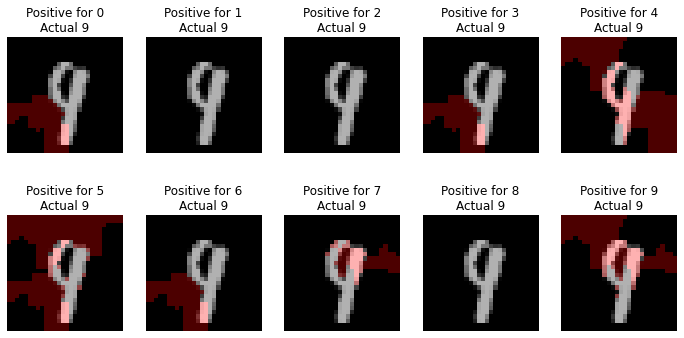

In [19]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')